# (15m) SNR

author: steeve.laquitaine@epfl.ch


**Method**
* Datasets  

    *`Marques` (aligned with cortical column)
        * rat cortex S1  
        * 384ch   
        * 30.0kHz  
        * 20.25 min  
        * "Spontaneous activity" (Only anesthetized condition)  

    * `Neuropixels` (aligned with cortical column)
        * run: 2023_10_18
        * rat cortex S1
        * 384ch 
        * 40.0kHz
        * 10 min
        * "Spontaneous activity" (Only anesthetized condition)

* SNR for first 10 mins (for speed)

### Prerequisites

These pipelines must have been run before:

1. fit silico amplitude and noise to in vivo per layer:

```bash
sbatch cluster/processing/fitting/marques/fit_marques_silico_l1.sbatch
sbatch cluster/processing/fitting/marques/fit_marques_silico_l2_3.sbatch
sbatch cluster/processing/fitting/marques/fit_marques_silico_l4.sbatch
sbatch cluster/processing/fitting/marques/fit_marques_silico_l5.sbatch
sbatch cluster/processing/fitting/marques/fit_marques_silico_l6.sbatch
```

2. Process silico traces:

```bash
sbatch cluster/prepro/marques_silico/process.sbatch
```

### Setup libs

Activate python3.9.7's spikeinterface 0.100.5 venv

In [1]:
# import libs
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import spikeinterface as si

# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023/"
os.chdir(PROJ_PATH)

from src.nodes import utils
from src.nodes.utils import get_config
from src.nodes.validation import amplitude, snr


# vivo [DONE]
data_conf_v, param_conf_h_v = get_config("vivo_marques", "c26").values() 
RAW_PATH_v = data_conf_v["raw"]
PREP_PATH_v = data_conf_v["preprocessing"]["output"]["trace_file_path"]
SNR_PATH_v = data_conf_v["postprocessing"]["trace_snr"]

# silico
data_conf_s, param_conf_s = get_config("silico_neuropixels", "concatenated").values()
RAW_PATH_s = data_conf_s["probe_wiring"]["40m"]["output_noise_fitd_gain_fitd_adj10perc_less_int16"]
PREP_PATH_s = data_conf_s["preprocessing"]["output"]["40m"]["trace_file_path_gain_fitd_adj10perc_less_noise_fitd_int16"]
SNR_PATH_s = data_conf_s["postprocessing"]["trace_snr_adj10perc_less_noise_fitd_int16"]

# buccino
data_conf_b, param_conf_b = get_config("buccino_2020", "2020").values()
RAW_PATH_b = data_conf_b["probe_wiring"]["10m"]["output_gain_fitd_int16"]
PREP_PATH_b = data_conf_b["preprocessing"]["output"]["trace_file_path_gain_ftd"]
SNR_PATH_b = data_conf_b["postprocessing"]["trace_snr"]

SFREQ_V = 30000        # sampling frequency
SFREQ_S = 40000        # sampling frequency

# FIGURE SETTINGS
COLOR_V = np.array([153,153,153]) / 255
COLOR_S = (0.84, 0.27, 0.2)
COLOR_B = np.array([55,126,184]) / 255

BOX_ASPECT = 1                  # square fig
LG_FRAMEON = False              # no legend frame
FIG_SIZE = (3, 3)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 30
plt.rcParams['lines.linewidth'] = 1.1
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.major.width'] = 0.8 * 1.3
plt.rcParams['ytick.major.width'] = 0.8 * 1.3
plt.rcParams['xtick.major.size'] = 3.5 * 2
plt.rcParams['xtick.minor.size'] = 2 * 2
plt.rcParams['ytick.major.size'] = 3.5 * 2
plt.rcParams['ytick.minor.size'] = 2 * 2

N_MAJOR_TICKS = 4
N_MINOR_TICKS = 12
YLIM = [1e-7, 1e8]
savefig_cfg = {"transparent":True}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}

2024-06-20 10:15:43,805 - root - utils.py - get_config - INFO - Reading experiment config.
2024-06-20 10:15:43,835 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-06-20 10:15:43,836 - root - utils.py - get_config - INFO - Reading experiment config.
2024-06-20 10:15:43,923 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-06-20 10:15:43,924 - root - utils.py - get_config - INFO - Reading experiment config.
2024-06-20 10:15:43,945 - root - utils.py - get_config - INFO - Reading experiment config. - done


### (1s)Compute SNR dist 

* first 10 mins
* for sites in cortex
* we plot: 
    * on logscale to increase the visibility of the SNR dist. which decays exponentially.
    * only the upper confidence interval (because the lower ci is uninformative; it goes to infinity when negative on a logscale)

In [5]:
# 1 - Load silico and vivo traces
RecS = si.load_extractor(PREP_PATH_s)
RecV = si.load_extractor(PREP_PATH_v)
RecB = si.load_extractor(PREP_PATH_b)

# 2. get first 10 mins
RecV = RecV.frame_slice(start_frame=0, end_frame=10 * 60 * SFREQ_V)
RecS = RecS.frame_slice(start_frame=0, end_frame=10 * 60 * SFREQ_S)

# 3. get traces
traces_s = RecS.get_traces()
traces_v = RecV.get_traces()
traces_b = RecB.get_traces()

In [6]:
# 4 - get good sites (in cortex)
# silico
lyrs = ["L1", "L2_3", "L4", "L5", "L6"]
site_lyrs_s = RecS.get_property("layers")
site_lyrs_s[site_lyrs_s == "L2"] = "L2_3"
site_lyrs_s[site_lyrs_s == "L3"] = "L2_3"
IN_CTX = np.isin(site_lyrs_s, lyrs)
sites_s = np.where(IN_CTX)[0]

# vivo
site_lyrs_v = RecV.get_property("layers")
IN_CTX = np.isin(site_lyrs_v, lyrs)
sites_v = np.where(IN_CTX)[0]

### (10m)Compute snrs

In [4]:
## (9m)compute snrs and save
# snr_s = snr.get_snrs_parallel(traces_s[:, sites_s])
# snr_v = snr.get_snrs_parallel(traces_v[:, sites_v])
# snr_b = snr.get_snrs_parallel(traces_b)
# utils.write_npy(snr_v, SNR_PATH_v)
# utils.write_npy(snr_s, SNR_PATH_s)
# utils.write_npy(snr_b, SNR_PATH_b)

# (47s) or load
snr_v = np.load(SNR_PATH_v)
snr_s = np.load(SNR_PATH_s)
snr_b = np.load(SNR_PATH_b)

In [7]:
# (2m) Keep traces in cortex
traces_s = traces_s[:, sites_s]
traces_v = traces_v[:, sites_v]
layers_s = site_lyrs_s[sites_s]
layers_v = site_lyrs_v[sites_v]
site_lyrs_s = site_lyrs_s[sites_s]
site_lyrs_v = site_lyrs_v[sites_v]

### (2m)Compute pdfs

In [ ]:
N_BINS = 100

# 1. calculate bins common across datasets (2 mins)
snr_max = np.max([np.array(snr_v).max(), np.array(snr_s).max(), np.array(snr_b).max()])
snr_min = np.min([np.array(snr_v).min(), np.array(snr_s).min(), np.array(snr_b).min()])
step = (snr_max - snr_min) / N_BINS
bins = np.arange(snr_min, snr_max + step / 2, step)

# 2. compute the mean and confidence intervals of the snrs pdfs over sites (1 min)
# vivo
mean_v, ci_v = amplitude.compute_anr_proba_dist_stats(snr_v, bins)
# silico
(
    mean_s,
    ci_s,
) = amplitude.compute_anr_proba_dist_stats(snr_s, bins)
# buccino
(
    mean_b,
    ci_b,
) = amplitude.compute_anr_proba_dist_stats(snr_b, bins)

# unit-test probabilities
assert 1 - sum(mean_v) < 1e-15, "should sum to 1"
assert 1 - sum(mean_s) < 1e-15, "should sum to 1"
assert 1 - sum(mean_b) < 1e-15, "should sum to 1"

# unit-test amplitudes (should be very close)
print("max silico:", np.absolute(traces_s).max())
print("max vivo:", np.absolute(traces_v).max())

max silico: 331
max silico: 362


### Plot All

* The dots below the x-axis line goes to -inf on a log scale because they are never observed (probability = 0)


In [64]:
# parameters
xlim = (-140, 50)
MARKERS = 10
MARKEREDGEW = 0.7

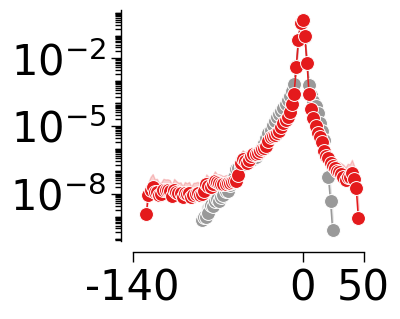

In [ ]:
# plot
fig_, axis = plt.subplots(1, 1, figsize=FIG_SIZE)

pm = {
    "linestyle": "-",
    "markersz": MARKERS,
    "markeredgew": MARKEREDGEW,
}

# vivo
amplitude.plot_proba_dist_stats(
    axis,
    mean_v[mean_v > 0],
    ci_v[mean_v > 0],
    bins[:-1][mean_v > 0],
    color=COLOR_V,
    ci_color=COLOR_V,
    label="vivo",
    **pm
)
# silico
amplitude.plot_proba_dist_stats(
    axis,
    mean_s[mean_s > 0],
    ci_s[mean_s > 0],
    bins[:-1][mean_s > 0],
    color=COLOR_S,
    ci_color=COLOR_S,
    label="silico",
    **pm
)
# legend
axis.set_yscale("log")
axis.spines[["right", "top"]].set_visible(False)
axis.tick_params(which="both", width=1)
axis.set_box_aspect(1)  # square axis

# show minor ticks
axis.tick_params(which="major", width=1)
# y
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
    numticks=N_MINOR_TICKS,
)
axis.yaxis.set_major_locator(locmaj)
axis.yaxis.set_minor_locator(locmin)
axis.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

# disconnect axes (R style)
axis.spines["bottom"].set_position(("axes", -0.05))
axis.yaxis.set_ticks_position("left")
axis.spines["left"].set_position(("axes", -0.05))
axis.set_xticks([-140, 0, 50], [-140, 0, 50])
axis.set_xlim(xlim)


# # save
plt.savefig("figures/2_realism/3_snr/svg/marques/snr_all.svg", **savefig_cfg)

#### L1

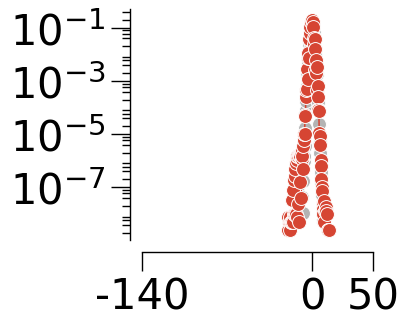

In [67]:
snr.plot_layer_snr(
    "L1",
    site_lyrs_s,
    site_lyrs_v,
    snr_s,
    snr_v,
    100,
    xlim=xlim,
    markersz=MARKERS,
    markeredgew=MARKEREDGEW,
)
plt.savefig("figures/2_realism/3_snr/svg/marques/snr_lyr1.svg", **savefig_cfg)

### (30s)L2/3

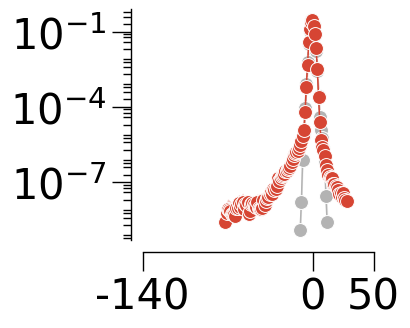

In [68]:
axis = snr.plot_layer_snr(
    "L2_3",
    site_lyrs_s,
    site_lyrs_v,
    snr_s,
    snr_v,
    100,
    xlim=xlim,
    markersz=MARKERS,
    markeredgew=MARKEREDGEW,
)
plt.savefig("figures/2_realism/3_snr/svg/marques/snr_lyr23.svg", **savefig_cfg)

### (30s)L4


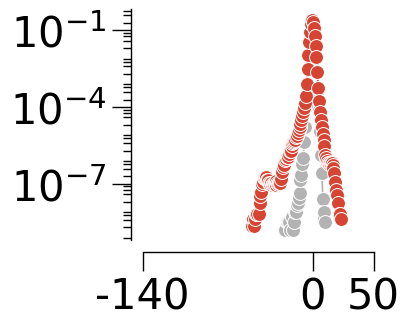

In [69]:
snr.plot_layer_snr(
    "L4",
    site_lyrs_s,
    site_lyrs_v,
    snr_s,
    snr_v,
    100,
    xlim=xlim,
    markersz=MARKERS,
    markeredgew=MARKEREDGEW,
)
plt.savefig("figures/2_realism/3_snr/svg/marques/snr_lyr4.svg", **savefig_cfg)

### (2.5m)L5

In [76]:
snr.plot_snr_for_layer_5(
    site_lyrs_s,
    site_lyrs_v,
    snr_s,
    snr_v,
    snr_b,
    100,
    xlim=xlim,
    markersz=MARKERS,
    markeredgew=MARKEREDGEW,
)
plt.savefig("figures/2_realism/3_snr/svg/marques/snr_lyr5.svg", **savefig_cfg)

### (1.5m)L6

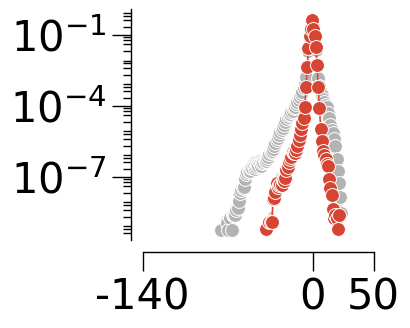

In [71]:
snr.plot_layer_snr(
    "L6",
    site_lyrs_s,
    site_lyrs_v,
    snr_s,
    snr_v,
    100,
    xlim=xlim,
    markersz=MARKERS,
    markeredgew=MARKEREDGEW,
)
plt.savefig("figures/2_realism/3_snr/svg/marques/snr_lyr6.svg", **savefig_cfg)

# References

(1) https://gin.g-node.org/spikeinterface/probeinterface_library/src/master/neuronexus/A1x32-Poly3-10mm-50-177/A1x32-Poly3-10mm-50-177.json

(2) Horváth et al., “Dataset of Cortical Activity Recorded with High Spatial Resolution from Anesthetized Rats.”

(3) Fiáth, R., Raducanu, B. C., Musa, S., Andrei, A., Lopez, C. M., Van Hoof, C., ... & Ulbert, I. (2018). A silicon-based neural probe with densely-packed low-impedance titanium nitride microelectrodes for ultrahigh-resolution in vivo recordings. Biosensors and Bioelectronics, 106, 86-92.  